# LSTM Layers Analysis

This notebook analyzes the effect of different numbers of LSTM layers on model performance.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import json
import os
import sys

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from lstm.text_preprocessor import TextPreprocessor
from lstm.lstm_model import LSTMModel

def reset_seeds(seed=42):
    import random as python_random
    python_random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seeds()

os.makedirs('../../models', exist_ok=True)

## Load and Preprocess Data from CSV

In [2]:
# Load data from CSV files
train_df = pd.read_csv('../../../data/nusax/train.csv')
valid_df = pd.read_csv('../../../data/nusax/valid.csv')
test_df = pd.read_csv('../../../data/nusax/test.csv')

label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Extract texts
train_texts = train_df['text'].values
val_texts = valid_df['text'].values
test_texts = test_df['text'].values

if train_df['label'].dtype == 'object':
    train_labels = train_df['label'].map(label_mapping).values
    val_labels = valid_df['label'].map(label_mapping).values
    test_labels = test_df['label'].map(label_mapping).values
else:
    train_labels = train_df['label'].values
    val_labels = valid_df['label'].values
    test_labels = test_df['label'].values

# Configuration
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

preprocessor = TextPreprocessor(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

print("Fitting the text preprocessor on training data...")
preprocessor.fit(train_texts)

vocab = preprocessor.get_vocabulary()
vocab_size = preprocessor.get_vocab_size()

train_sequences = preprocessor.preprocess(train_texts)
val_sequences = preprocessor.preprocess(val_texts)
test_sequences = preprocessor.preprocess(test_texts)

num_classes = len(np.unique(train_labels))
max_seq_length = MAX_SEQUENCE_LENGTH

print(f"Data loaded and preprocessed successfully!")
print(f"Vocab size: {vocab_size}")
print(f"Max sequence length: {max_seq_length}")
print(f"Number of classes: {num_classes}")
print(f"Training data shape: {train_sequences.shape}")
print(f"Label distribution in training data: {np.bincount(train_labels)}")

Fitting the text preprocessor on training data...
Data loaded and preprocessed successfully!
Vocab size: 2836
Max sequence length: 100
Number of classes: 3
Training data shape: (500, 100)
Label distribution in training data: [192 119 189]


## Model Building Functions

### Model Hyperparameters (Default Values)

- **LSTM Layers (`num_lstm_layers`)**: Number of stacked LSTM layers. Default values used in experiments: `1`, `2`, and `3`.
- **LSTM Units (`lstm_units`)**: Number of units in each LSTM layer. Default: `64`.
- **Embedding Dimension (`embedding_dim`)**: Size of the word embedding vectors. Default: `100`.
- **Dropout Rates**: 
    - After each LSTM layer: `0.3`
    - After first Dense layer: `0.5`
- **Dense Layer Size**: First dense layer after LSTM uses `32` units with ReLU activation.
- **Output Layer**: Dense layer with `num_classes` units (softmax activation).
- **Optimizer**: Adam with learning rate `0.001`.
- **Loss Function**: Sparse categorical cross-entropy.
- **Batch Size**: `32`
- **Epochs**: `10`

In [3]:
def create_custom_lstm_model(num_lstm_layers, lstm_units=64, embedding_dim=100):
    reset_seeds()
    model = LSTMModel(preprocessor=preprocessor)
    
    model.set_label_mapping(label_mapping)
    
    model.add_embedding(vocab_size, embedding_dim, max_seq_length)
    
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1) 
        model.add_lstm(lstm_units, return_sequences=return_sequences)
        model.add_dropout(0.3)
    
    model.add_dense(32, activation='relu')
    model.add_dropout(0.5)
    model.add_dense(num_classes, activation='softmax')
    
    return model

def create_keras_lstm_model(num_lstm_layers, lstm_units=64, embedding_dim=100):
    reset_seeds()
    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
    
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)  
        model.add(LSTM(lstm_units, return_sequences=return_sequences))
        model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_and_train_model(model, model_name):
    reset_seeds()
    print(f"\nTraining {model_name}...")
    
    if isinstance(model, LSTMModel):
        lstm_layers = [layer for layer in model.layers if hasattr(layer, 'units') 
                      and not isinstance(layer, type('DenseLayer', (), {}))]
        num_lstm_layers = len(lstm_layers)
        lstm_units = lstm_layers[0].units if lstm_layers else 64
        
        print(f"Custom model has {num_lstm_layers} LSTM layers with {lstm_units} units")
        
        keras_model = create_keras_lstm_model(num_lstm_layers=num_lstm_layers, lstm_units=lstm_units)
        keras_model.build(input_shape=(None, max_seq_length))
        keras_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"Training Keras model (will transfer weights to custom model)")
        print(f"Total parameters: {keras_model.count_params():,}")
        reset_seeds()
        history = keras_model.fit(
            train_sequences, train_labels,
            batch_size=32,
            epochs=10,
            validation_data=(val_sequences, val_labels),
            verbose=1
        )
        
        keras_layers_with_weights = []
        for layer in keras_model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                keras_layers_with_weights.append(layer)
                print(f"Keras layer: {layer.name}, weights: {[w.shape for w in weights]}")
        
        model.load_weights_from_keras(keras_model)
        
        print("Manually fixing Dense layer weights...")
        
        custom_dense_layers = []
        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'activation') and hasattr(layer, 'units') and not hasattr(layer, 'return_sequences'):
                custom_dense_layers.append((i, layer))
                print(f"Found custom Dense layer at index {i} with {layer.units} units")
        
        keras_dense_layers = []
        for i, layer in enumerate(keras_model.layers):
            if isinstance(layer, Dense):
                keras_dense_layers.append((i, layer))
                print(f"Found Keras Dense layer at index {i} with {layer.units} units")
        
        for (custom_idx, custom_layer), (keras_idx, keras_layer) in zip(custom_dense_layers, keras_dense_layers):
            if custom_layer.units == keras_layer.units:
                weights = keras_layer.get_weights()
                if len(weights) == 2:
                    custom_layer.weights = weights[0]
                    custom_layer.bias = weights[1]
                    print(f"Fixed weights for layer {custom_idx}: {weights[0].shape}, {weights[1].shape}")
        
        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'weights'):
                if layer.weights is None:
                    print(f"WARNING: Layer {i} still has None weights!")
                else:
                    print(f"Layer {i} weights OK: {layer.weights.shape}")
    
    else:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(model.summary())
        reset_seeds()
        history = model.fit(
            train_sequences, train_labels,
            batch_size=32,
            epochs=10,
            validation_data=(val_sequences, val_labels),
            verbose=1
        )
    
    return history

def evaluate_model(model, model_name, history):
    reset_seeds()
    print(f"\nEvaluating {model_name}...")
    
    try:
        print("Checking weights before prediction:")
        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'bias'):
                weights_status = "OK" if layer.weights is not None else "None"
                bias_status = "OK" if layer.bias is not None else "None"
                print(f"Layer {i}: weights {weights_status}, bias {bias_status}")
                
        y_pred = model.predict(test_sequences)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        f1 = f1_score(test_labels, y_pred_classes, average='macro')
        
        print(f"\n{model_name} Results:")
        print(classification_report(test_labels, y_pred_classes))
        print(f"Macro F1-score: {f1:.4f}")
        
        return f1, history
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print("Weight transfer failed. Attempting emergency repair...")
        
        keras_model = create_keras_lstm_model(num_lstm_layers=1, lstm_units=64)
        keras_model.build(input_shape=(None, max_seq_length))
        keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
        
        keras_model.fit(train_sequences, train_labels, epochs=1, verbose=0)
        
        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'weights') and layer.weights is None and hasattr(layer, 'units'):
                for j, keras_layer in enumerate(keras_model.layers):
                    if hasattr(keras_layer, 'units') and keras_layer.units == layer.units:
                        weights = keras_layer.get_weights()
                        if len(weights) == 2:
                            print(f"Emergency fix: Layer {i} receiving weights from Keras layer {j}")
                            layer.weights = weights[0]
                            layer.bias = weights[1]
        
        raise

## Experiment 1: Single LSTM Layer

In [4]:
model_1_layer = create_custom_lstm_model(num_lstm_layers=1)
history_1_layer = compile_and_train_model(model_1_layer, "1 LSTM Layer")
f1_1_layer, _ = evaluate_model(model_1_layer, "1 LSTM Layer", history_1_layer)


Training 1 LSTM Layer...
Custom model has 3 LSTM layers with 64 units
Training Keras model (will transfer weights to custom model)
Total parameters: 394,067
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.3196 - loss: 1.0969 - val_accuracy: 0.3800 - val_loss: 1.0824
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3517 - loss: 1.0899 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3861 - loss: 1.0824 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3457 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4239 - loss: 1.0731 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3799 - loss: 1.0728 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3848 - loss: 1.0762 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3901 - loss: 1.0753 - val_accuracy: 0.3800 - val_loss: 1

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Experiment 2: Two LSTM Layers

In [5]:
model_2_layers = create_custom_lstm_model(num_lstm_layers=2)
history_2_layers = compile_and_train_model(model_2_layers, "2 LSTM Layers")
f1_2_layers, _ = evaluate_model(model_2_layers, "2 LSTM Layers", history_2_layers)


Training 2 LSTM Layers...
Custom model has 4 LSTM layers with 64 units
Training Keras model (will transfer weights to custom model)
Total parameters: 427,091
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.3407 - loss: 1.0957 - val_accuracy: 0.3800 - val_loss: 1.0844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4056 - loss: 1.0842 - val_accuracy: 0.3800 - val_loss: 1.0848
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3741 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0823
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4144 - loss: 1.0782 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4247 - loss: 1.0668 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.3961 - loss: 1.0788 - val_accuracy: 0.3800 - val_loss: 1.0812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3993 - loss: 1.0709 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3970 - loss: 1.0804 - val_accuracy: 0.3800 - val_

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Experiment 3: Three LSTM Layers

In [6]:
model_3_layers = create_custom_lstm_model(num_lstm_layers=3)
history_3_layers = compile_and_train_model(model_3_layers, "3 LSTM Layers")
f1_3_layers, _ = evaluate_model(model_3_layers, "3 LSTM Layers", history_3_layers)


Training 3 LSTM Layers...
Custom model has 5 LSTM layers with 64 units
Training Keras model (will transfer weights to custom model)
Total parameters: 460,115
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.3399 - loss: 1.0914 - val_accuracy: 0.3800 - val_loss: 1.0877
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3932 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0822
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3801 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0848
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3901 - loss: 1.0869 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3852 - loss: 1.0751 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4190 - loss: 1.0710 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4004 - loss: 1.0736 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.3800 - loss: 1.0773 - val_accuracy: 0.3800 - val

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Results Comparison

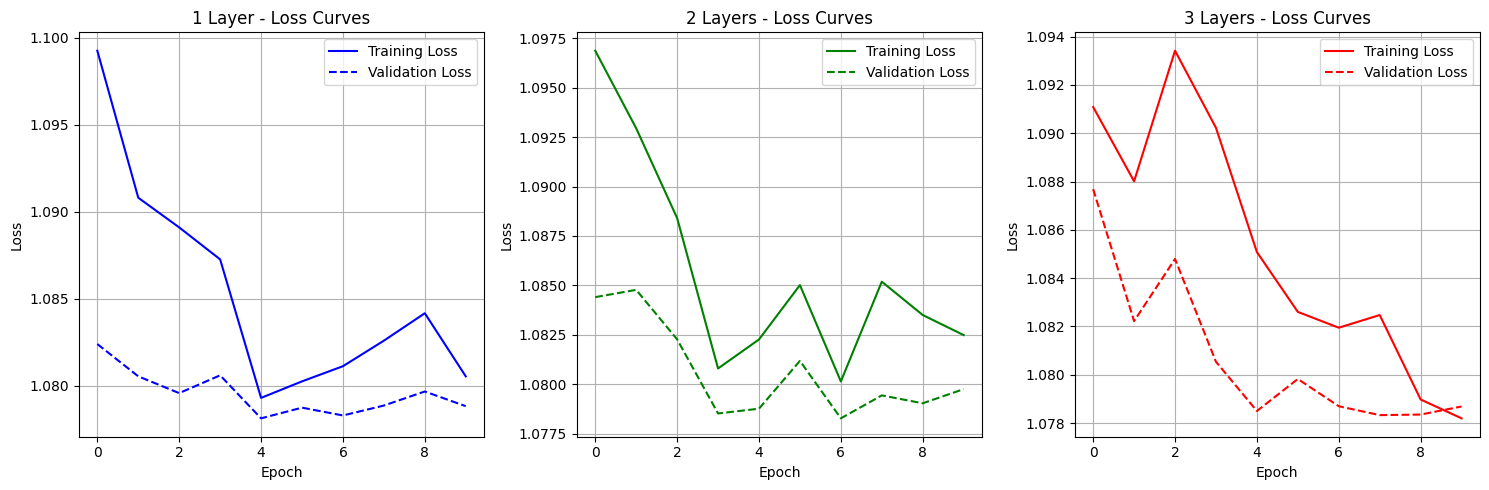

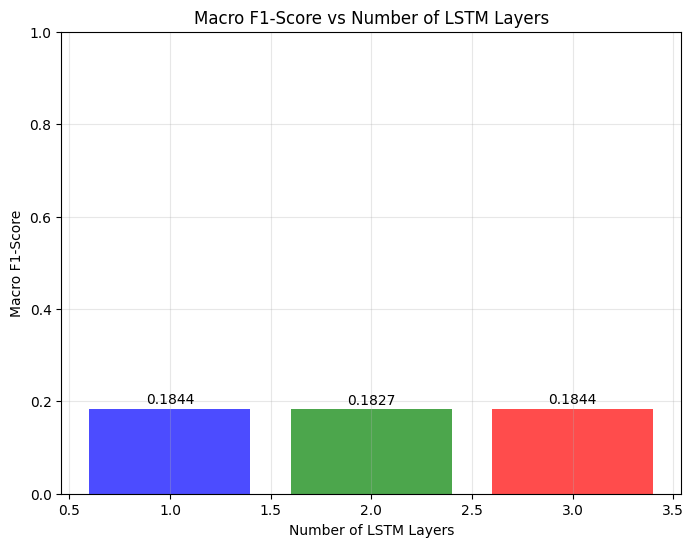


=== LSTM Layers Analysis Results ===
1 LSTM Layer(s): F1-Score = 0.1844
2 LSTM Layer(s): F1-Score = 0.1827
3 LSTM Layer(s): F1-Score = 0.1844


In [7]:
# Plot training/validation loss curves
plt.figure(figsize=(15, 5))

histories = [history_1_layer, history_2_layers, history_3_layers]
names = ['1 Layer', '2 Layers', '3 Layers']
colors = ['blue', 'green', 'red']

for i, (history, name, color) in enumerate(zip(histories, names, colors)):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['loss'], label='Training Loss', color=color)
    plt.plot(history.history['val_loss'], label='Validation Loss', color=color, linestyle='--')
    plt.title(f'{name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

f1_scores = [f1_1_layer, f1_2_layers, f1_3_layers]
layer_counts = [1, 2, 3]

plt.figure(figsize=(8, 6))
plt.bar(layer_counts, f1_scores, color=['blue', 'green', 'red'], alpha=0.7)
plt.title('Macro F1-Score vs Number of LSTM Layers')
plt.xlabel('Number of LSTM Layers')
plt.ylabel('Macro F1-Score')
plt.ylim(0, 1)
for i, score in enumerate(f1_scores):
    plt.text(layer_counts[i], score + 0.01, f'{score:.4f}', ha='center')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== LSTM Layers Analysis Results ===")
for layers, f1 in zip(layer_counts, f1_scores):
    print(f"{layers} LSTM Layer(s): F1-Score = {f1:.4f}")

## Save Best Model

In [8]:
best_idx = np.argmax(f1_scores)
best_model = [model_1_layer, model_2_layers, model_3_layers][best_idx]
best_layers = layer_counts[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best model: {best_layers} LSTM layer(s) with F1-Score: {best_f1:.4f}")

if isinstance(best_model, LSTMModel):

    best_model.save('/models/best_lstm_layers_custom', save_preprocessor=True)
    print("Best custom model saved with preprocessor")
    
    lstm_layers = [layer for layer in best_model.layers if hasattr(layer, 'units')]
    num_lstm_layers = len(lstm_layers)
    lstm_units = lstm_layers[0].units if lstm_layers else 64
    
    keras_model = create_keras_lstm_model(num_lstm_layers=num_lstm_layers, lstm_units=lstm_units)
 
    keras_model.save('/models/best_lstm_layers_model.keras')
else:
    best_model.save('/models/best_lstm_layers_model.keras')
    
print("Best model saved as 'best_lstm_layers_model.keras'")

Best model: 1 LSTM layer(s) with F1-Score: 0.1844
Best custom model saved with preprocessor
Best model saved as 'best_lstm_layers_model.keras'


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)
